<a href="https://colab.research.google.com/github/andrewmarcello1-dev/Portfolio/blob/main/MA510_FinalProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Constants

p = 1.225 kg/m^3 (Air density) (same source as for wind turbine specs)

-----
Note: For wind turbine, I'm using the Vestas V80/1800 model

A = 5,027 m^2

C_p = 0.45

v_cut-in = 3.5 m/s (mininum wind speed for the turbine to activate)

v_rated = 15 m/s (wind speed at which the turbine produces its maximum power)

v_cut-out = 30 m/s (wind speed at which the turbines will shut down to avoid dangerous mechanical stress)

P_rated = 1,800 kW (power output of the turbine at wind speed v_rated)

y_max and x_max = 5000m (i.e., the wind farm has a 75 MW installed capacity, using a 3MW/km^2 average land area requirement)

D  = 7d for up/down stream (let's say this is they y direction); 3d for side to side (x direction); (D is the minimum "safe" distance between turbines; based on wake effect (don't try to accurately do this pls), can look more into this or can choose an arbitrary value)

d = 80 m (rotor diameter)


----

##Model Parameters

w (inertia coefficient in PSO algorithm)

c_1, r_1, c_2, r_2 (cognitive and social coefficients in the PSO)



##Formulation of the Problem

Max z = SUM(P_i(v))

P(v) =
- 0 if v < 3.5 m/s
- 1386v^3 kW if 3.5m/s <= v < 15m/s
- 1800 kW if 15m/s <= v < 30 m/s
- 0 if 30 m/s <= v

S.t
    - | x_i - x_j | <= 3d

    - | y_i - y_j | <= 7d

    - y_i <= 2500m

    - x_i <= 2500m

    - x_i, y_i >= 0



TASKS

- Determine constants and feasibility requirements by
11/24

- Have math and code worked out by 12/1

- Have report and power point done by 12/8

In [ ]:
# Imports
import numpy as np
!pip install pyswarms
import pyswarms as ps
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(42)  # Fixed seed for reproducibility

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
def enforce_distance_constraint(positions, min_distance=200, max_iterations=1000):
    """Adjust positions of particles iteratively to enforce the minimum distance constraint and boundary conditions."""
    iteration = 0

    while iteration < max_iterations:
        adjustment_needed = False
        for i in range(len(positions)):
            for j in range(i + 1, len(positions)):
                if np.linalg.norm(positions[i] - positions[j]) < min_distance:
                    adjustment_needed = True

                    # Move particle j away from particle i
                    direction = positions[j] - positions[i]
                    norm_direction = direction / np.linalg.norm(direction)
                    adjustment = norm_direction * min_distance
                    mid_point = (positions[i] + positions[j]) / 2
                    new_position_i = mid_point - adjustment / 2
                    new_position_j = mid_point + adjustment / 2

                    # Enforce boundary conditions
                    positions[i] = np.clip(new_position_i, 0, 2500)
                    positions[j] = np.clip(new_position_j, 0, 2500)

        if not adjustment_needed:
            break

        iteration += 1

    return positions

def f_per_particle(m): # Function for Power
    """Computes for the function value of particle m."""
    x, y = m  # Unpack the position of particle m
    cp = 0.173
    R = 40


    A = np.pi * R**2
    p = 1.225
    v = (2 * 10**(-6)) * ((x - 2500)**2 + (y - 2500)**2)
    if v < 3:
        P = 0
    if 0 <= v < 15: #switch this upper bound to 15, since this is the rated windspeed for the turbine
        P = 0.5 * cp * p * A * v**3
    elif 15 <= v < 30:
        P = 1800000 #1800 kW, the rated power for these turbines
    else:
        P = 0
    return -P  # Negate since we want to maximize P

def f(x, *args):
    """Higher-level method to do f(x) for all particles."""
    n_particles = x.shape[0]
    j = [f_per_particle(x[i]) for i in range(n_particles)]
    return np.array(j)

In [ ]:
# Define the bounds of the search space
bounds = (np.array([0, 0]), np.array([2500, 2500]))

# Initialize swarm, arbitrary
options = {'c1': 0.01, 'c2': 0.01, 'w':0.9}

# Initialize and run the PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)
cost, pos = optimizer.optimize(f, iters=1000)
particle_positions0 = np.random.uniform(low=bounds[0], high=bounds[1], size=(10, 2))

# Access and adjust positions of all particles to enforce the distance constraint
particle_positions = optimizer.swarm.position
plot_positions = particle_positions

2023-12-08 20:11:11,590 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.01, 'c2': 0.01, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.8e+6
2023-12-08 20:11:17,489 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1800000.0, best pos: [274.52653235 886.69704001]


In [ ]:
# Print the positions of particles and the power produced by each particle
print("Positions and Power of each particle before enforcing distance constraint:")
total_power = 0
for i, position in enumerate(particle_positions):
    particle_power = -f_per_particle(position) / 1e6  # Convert power to megawatts
    print(f"Particle {i+1}: Position: [{position[0]:.3f}, {position[1]:.3f}]\n\t    Power: {particle_power:.3f} MW")
    total_power += particle_power

# Print the total power produced in megawatts
print(f"Total Power produced by all particles: {total_power:.3f} MW")

Positions and Power of each particle before enforcing distance constraint:
Particle 1: Position: [246.848, 720.769]
	    Power: 1.800 MW
Particle 2: Position: [195.764, 732.854]
	    Power: 1.800 MW
Particle 3: Position: [276.359, 637.401]
	    Power: 1.800 MW
Particle 4: Position: [313.388, 599.294]
	    Power: 1.800 MW
Particle 5: Position: [441.949, 487.466]
	    Power: 1.800 MW
Particle 6: Position: [400.877, 505.773]
	    Power: 1.800 MW
Particle 7: Position: [376.349, 541.604]
	    Power: 1.800 MW
Particle 8: Position: [361.906, 532.976]
	    Power: 1.800 MW
Particle 9: Position: [221.231, 489.957]
	    Power: 1.800 MW
Particle 10: Position: [176.459, 628.642]
	    Power: 1.800 MW
Total Power produced by all particles: 18.000 MW


(0.0, 2500.0)

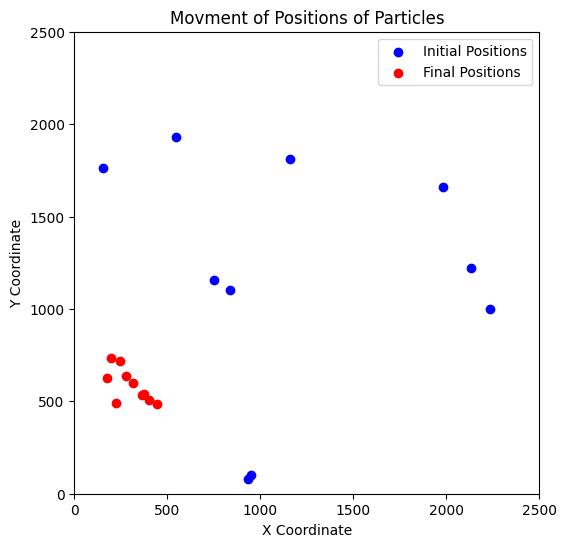

In [ ]:
plt.figure(figsize=(6, 6))

# Plot Initial Positions
plt.plot()
plt.scatter(particle_positions0[:, 0], particle_positions0[:, 1], color='blue', label='Initial Positions')

# Plot Final Positions
plt.scatter(particle_positions[:, 0], particle_positions[:, 1], color='red', label='Final Positions')
plt.title('Movment of Positions of Particles')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.xlim(bounds[0][0], bounds[1][0])
plt.ylim(bounds[0][1], bounds[1][1])

In [ ]:
# Enforce Distance Constraint to Evenly Space Particles About Optimum Position
final_positions = enforce_distance_constraint(particle_positions)

# Print the positions of particles and the power produced by each particle
print("Positions and Power of each particle after enforcing distance constraint:")
total_power = 0
for i, position in enumerate(final_positions):
    particle_power = -f_per_particle(position) / 1e6  # Convert power to megawatts
    print(f"Particle {i+1}: Position: [{position[0]:.3f}, {position[1]:.3f}]\n\t    Power: {particle_power:.3f} MW")
    total_power += particle_power

# Print the total power produced in megawatts
print(f"Total Power produced by all particles: {total_power:.3f} MW")

Positions and Power of each particle after enforcing distance constraint:
Particle 1: Position: [420.315, 849.093]
	    Power: 1.493 MW
Particle 2: Position: [120.155, 863.014]
	    Power: 1.800 MW
Particle 3: Position: [72.821, 667.749]
	    Power: 1.800 MW
Particle 4: Position: [265.343, 722.666]
	    Power: 1.800 MW
Particle 5: Position: [610.380, 378.625]
	    Power: 1.800 MW
Particle 6: Position: [263.164, 318.265]
	    Power: 1.800 MW
Particle 7: Position: [543.128, 626.854]
	    Power: 1.684 MW
Particle 8: Position: [428.901, 462.682]
	    Power: 1.800 MW
Particle 9: Position: [48.245, 463.337]
	    Power: 1.800 MW
Particle 10: Position: [238.679, 524.451]
	    Power: 1.800 MW
Total Power produced by all particles: 17.577 MW


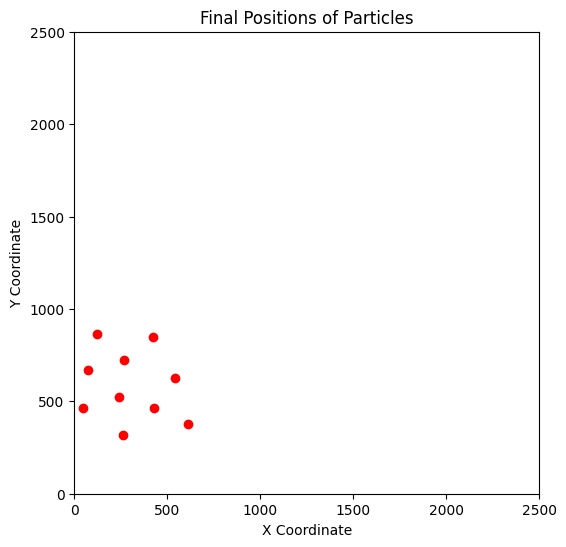

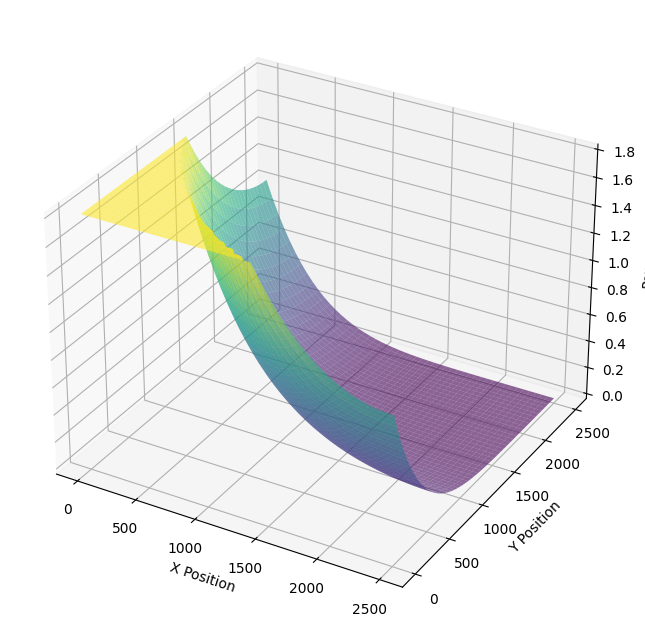

In [ ]:
plt.figure(figsize=(6, 6))

# Plot Final Positions
plt.plot(1, 2, 2)
plt.scatter(final_positions[:, 0], final_positions[:, 1], color='red')
plt.title('Final Positions of Particles')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(bounds[0][0], bounds[1][0])
plt.ylim(bounds[0][1], bounds[1][1])

# Plotting Optimum Points in 3D

# Create a grid of x, y values
x = np.linspace(0, 2500, 50)
y = np.linspace(0, 2500, 50)
X, Y = np.meshgrid(x, y)  # Create a meshgrid for plane positions

# Initialize an array for pr values
pr_values = np.zeros(X.shape)

# Calculate pr values for each point in the grid
for i in range(len(x)):
    for j in range(len(y)):
        pos = (X[i, j], Y[i, j])  # Get the position from the meshgrid
        pr = -f_per_particle(pos)  # Calculate pr assuming this function exists
        pr_values[i, j] = pr

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, pr_values, cmap='viridis', alpha=0.6)

# Plot the particles
particle_powers = [-f_per_particle(pos) for pos in final_positions]  # Adjust the calculation as needed
particle_x = [pos[0] for pos in final_positions]
particle_y = [pos[1] for pos in final_positions]
ax.scatter(particle_x, particle_y, particle_powers, color='red')

# Set labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Power')

# Show the plot
plt.show()